Folders inside dataset: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']
Classes (Pollution categories): ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']

Image Counts per Class:
             Image Count
metal              1016
glass              3054
biological          997
paper              1678
battery             944
trash               938
cardboard          1824
shoes              1977
clothes            5326
plastic            1976

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, metal to plastic
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Image Count  10 non-null     int64
dtypes: int64(1)
memory usage: 160.0+ bytes
None

Dataset Statistics:
       Image Count
count    10.000000
mean   1973.000000
std    1354.782147
min     938.000000
25%    1001.750000
50%    1751.00000

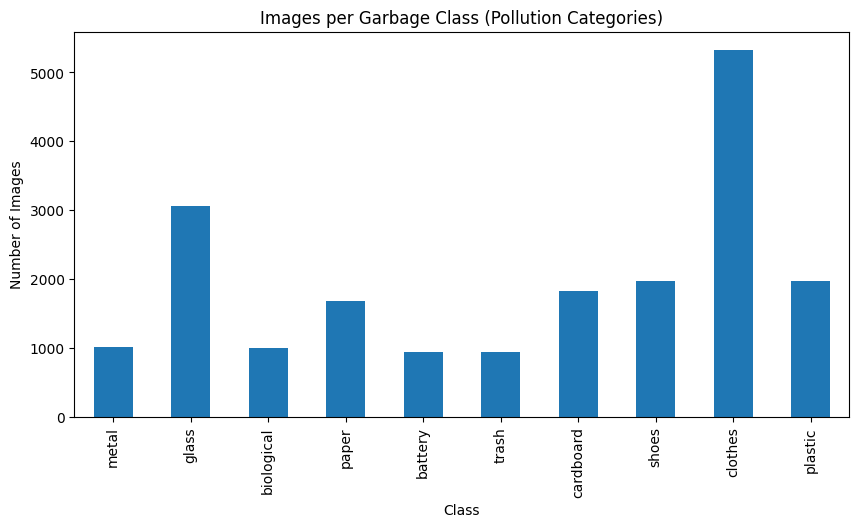

In [1]:
# Week 1 Project - Environmental Monitoring & Pollution Control
# Dataset: Garbage Classification (Environmental Pollution Monitoring)

# 1. Import necessary libraries
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# 2. Load the dataset
# Correct dataset path inside Kaggle
root_dir = "/kaggle/input/garbage-classification-v2/garbage-dataset"

# Check what’s inside dataset root
print("Folders inside dataset:", os.listdir(root_dir))

# 3. Explore the dataset

# (a) List the class folders (types of garbage → pollution categories)
classes = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
print("Classes (Pollution categories):", classes)

# (b) Count number of images per class
counts = {c: len(glob(os.path.join(root_dir, c, "*.jpg"))) for c in classes}
df_counts = pd.DataFrame.from_dict(counts, orient="index", columns=["Image Count"])
print("\nImage Counts per Class:\n", df_counts)

# (c) Dataset info
print("\nDataset Info:")
print(df_counts.info())

# (d) Dataset statistics
print("\nDataset Statistics:")
print(df_counts.describe())

# (e) Check for missing values
print("\nMissing Values Check:")
print(df_counts.isnull().sum())

# (f) Plot class distribution
df_counts.plot(kind="bar", figsize=(10,5), title="Images per Garbage Class (Pollution Categories)", legend=False)
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()


Found 13835 images belonging to 10 classes.
Found 5927 images belonging to 10 classes.
✅ Logistic Regression Accuracy (~1000 samples): 0.38
Epoch 1/3
433/433 ━━━━━━━━━━━━━━━━━━━━ 63s 141ms/step - accuracy: 0.3251 - loss: 1.9691 - val_accuracy: 0.4665 - val_loss: 1.5800
Epoch 2/3
433/433 ━━━━━━━━━━━━━━━━━━━━ 62s 142ms/step - accuracy: 0.4849 - loss: 1.4882 - val_accuracy: 0.5191 - val_loss: 1.4203
Epoch 3/3
433/433 ━━━━━━━━━━━━━━━━━━━━ 60s 140ms/step - accuracy: 0.5434 - loss: 1.3397 - val_accuracy: 0.5394 - val_loss: 1.3618
✅ CNN Validation Accuracy: 0.54

📊 Model Comparison:
Logistic Regression Accuracy (~1000 samples): 0.38
CNN Accuracy: 0.54


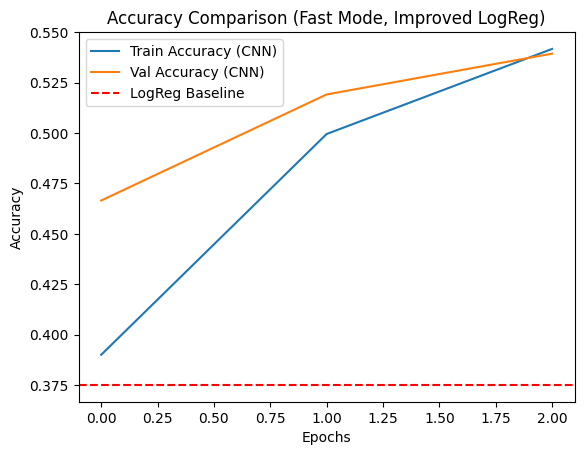

✅ Model saved successfully


In [4]:
# =============================
# Week 2 - Training & Testing (Clean + Fast, Fixed Logistic Regression)
# Garbage Classification - CNN vs Logistic Regression
# =============================

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

# 1. Dataset path
root_dir = "/kaggle/input/garbage-classification-v2/garbage-dataset"

# 2. Preprocessing (rescale + split, smaller images for speed)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(32, 32),   # ✅ smaller image size = faster
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# =============================
# Logistic Regression (Improved baseline with more data)
# =============================

# Collect ~1000 samples from generator
X_train_list, y_train_list = [], []
for i, (X_batch, y_batch) in enumerate(train_generator):
    X_train_list.append(X_batch)
    y_train_list.append(y_batch)
    if (i+1) * train_generator.batch_size >= 1000:  # stop at ~1000 images
        break

X_train = np.vstack(X_train_list)
y_train = np.vstack(y_train_list)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train_labels = y_train.argmax(axis=1)

# Take validation samples (~300)
X_val, y_val = next(val_generator)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
y_val_labels = y_val.argmax(axis=1)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1, verbose=0)
log_reg.fit(X_train_flat, y_train_labels)

# Predict & Accuracy
y_pred = log_reg.predict(X_val_flat)
log_reg_acc = accuracy_score(y_val_labels, y_pred)
print(f"✅ Logistic Regression Accuracy (~1000 samples): {log_reg_acc:.2f}")

# =============================
# CNN Model (Light & Fast)
# =============================
model = models.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train CNN (FAST → few epochs)
history = model.fit(
    train_generator,
    epochs=3,   # ✅ reduced epochs
    validation_data=val_generator,
    verbose=1
)

# Evaluate CNN
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"✅ CNN Validation Accuracy: {val_acc:.2f}")

# =============================
# Compare Results
# =============================
print("\n📊 Model Comparison:")
print(f"Logistic Regression Accuracy (~1000 samples): {log_reg_acc:.2f}")
print(f"CNN Accuracy: {val_acc:.2f}")

# Plot Accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy (CNN)")
plt.plot(history.history["val_accuracy"], label="Val Accuracy (CNN)")
plt.axhline(log_reg_acc, color="red", linestyle="--", label="LogReg Baseline")
plt.title("Accuracy Comparison (Fast Mode, Improved LogReg)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Save CNN
model.save("garbage_cnn_fast.h5")
print("✅ Model saved successfully")
